<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/Advantage_Actor_Critic_cartpole_ent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import time

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

# Agent

In [2]:
class Agent_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1  = nn.Linear(4, 32)
        self.act1 = nn.ReLU()

        self.fc2  = nn.Linear(32, 32)
        self.act2 = nn.ReLU()

        self.pi_net = nn.Linear(32, 2)
        self.pi_act = nn.Softmax()

        self.V_net = nn.Linear(32,1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        pi = self.pi_net(x)
        pi = self.pi_act(pi)

        V = self.V_net(x)
        return pi, V

In [3]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'pi_prob', 'v_value'))

class Agent_Memory():
    def __init__(self):
        self.capacity = ADVANTAGE #Advantageを計算するために、Xstep分の履歴を保存する
        self.memory = []
        self.index = 0
    
    def put_memory(self, state, action, reward, pi_prob, v_value):
        '''transition = (self, state, action, reward, pi_prob, v_value)をメモリに保存する'''
        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す
        self.memory[self.index] = Transition(state, action, reward, pi_prob, v_value)
        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす

    def get_Advantage(self, Last_V):
        transitions = self.memory
        #State, Action, Reward, State_Nextの各要素ごとにまとめ直しTensorに変換する
        BATCH = Transition(*zip(*transitions)) 
        State_BATCH   = torch.tensor( np.stack( BATCH.state ) ,dtype=torch.float)
        Action_BATCH  = torch.tensor( np.stack( BATCH.action ) ,dtype=torch.int64)
        Reward_BATCH  = torch.tensor( np.stack( BATCH.reward ) ,dtype=torch.float)
        Pi_prob_BATCH = torch.stack( BATCH.pi_prob )
        V_value_BATCH = torch.stack( BATCH.v_value )

        # Nstep分の割引報酬を計算し、Advantageを計算する
        Returns        = torch.zeros([Reward_BATCH.shape[0]+1]) 
        Returns[-1]  = Last_V
        for i in reversed(range(len(Reward_BATCH))):
            Returns[i] = Reward_BATCH[i]+GAMMA*Returns[i+1]
        Returns   = Returns[:-1].reshape(1,-1)
        Advantage = Returns.detach() - V_value_BATCH
        return Advantage.reshape(-1), Pi_prob_BATCH

In [4]:
class Agent():
    def __init__(self):
        self.Network = Agent_Network()
        self.Memory  = Agent_Memory()
        self.optim   = optim.Adam(self.Network.parameters(), lr=LR)
        self.scheduler = optim.lr_scheduler.StepLR(optimizer=self.optim, step_size=LR_STEP, gamma=LR_GAMMA)

    def get_action(self, state, episode): 
        # ε-greedy法で徐々に最適行動のみを採用する
        #self.Network.eval()  # ネットワークを推論モードに切り替える
        pi_values, V_value = self.Network( torch.tensor( state, dtype=torch.float ) )
        m = Categorical(pi_values)

        epsilon = 0.5 * (1 / (episode + 1))
        if epsilon <= np.random.uniform(0, 1):
            action = m.sample()
        else:
            action = np.random.choice(2)   # 0,1の行動をランダムに返す
            action = torch.tensor( action )
        #log_prob = -1 * m.log_prob(action)
        pi_prob = m.probs[ action.to(torch.long) ]
        return action, pi_prob, V_value[0]

    def update_Network(self, Last_V):
        # Memoryから学習用のデータを取り出す
        Advantage, Pi_prob_BATCH = self.Memory.get_Advantage(Last_V)

        V_loss  = Advantage.pow(2).mean() #２乗平均をとる
        Log_prob_BATCH = torch.log( Pi_prob_BATCH )
        pi_gain = ( Log_prob_BATCH * Advantage.detach() ).mean()
        entropy  = -1*( Pi_prob_BATCH * Log_prob_BATCH ).mean()

        loss = 0.5*V_loss - pi_gain - 0.01*entropy
        
        self.optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.Network.parameters(), CLIP)
        self.optim.step() 
        self.scheduler.step()

        self.Memory.memory = []
        self.Memory.index = 0
    
    def memorize(self, state, action, reward, pi_prob, v_value):
        self.Memory.put_memory(state, action, reward, pi_prob, v_value)

# Task

In [5]:
Task_model = gym.make('CartPole-v0')

# Training Environment

In [14]:
class Environment():
    def __init__(self):
        self.Task  = Task_model
        self.Agent = Agent()
    
    def run_one_episode(self, episode):
        # 倒れるか、200秒持ち堪え耐えるまでが１エピソード        
        t = 0
        state = self.Task.reset() # 各episodeの最初にTaskをリセット
        reword = 0

        while True:
            for advantage_step in range(ADVANTAGE): #Advantage分のStepsを1サイクルと考える
                action, pi_prob, v_value  = self.Agent.get_action(state, episode)
                state_next, reword, done, info = self.Task.step(action.item()) #Action_tを場面に渡してState_t+1, Reword_tを受け取る

                if done: #倒れていたor終了した場合
                    next_state = None
                    if t < 195: #195ステップいないなら失敗
                        reword = -1
                    else: #195ステップ以上たってたら成功
                        reword = 1
                else: #各ステップで立ってたら報酬追加
                    reword = 0

                # 結果の記録
                self.Agent.memorize(state, action, reword, pi_prob, v_value)
                state = state_next
                t += 1

                if done:# Advantageの途中で終わってたら抜ける
                    break 

            if state is not None:
                _, _, Last_V  = self.Agent.get_action(state, episode)
            else:
                Last_V = torch.tensor(0)
            self.Agent.update_Network(Last_V)
            if done: #全体のループを抜ける 
                break        
        return t
    
    def train(self):
        TIMES = []
        times = 0
        episode = 0
        while True:
            times = self.run_one_episode(episode)
            print('episode :', episode)
            print(times)
            print('='*10)
            episode += 1
            TIMES.append(times)

            if ( (len(TIMES) > 10) & (np.mean(TIMES[-10:]) >= 150) ) or (len(TIMES) > MAX_ITER):
                break
        return TIMES

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


episode : 0
14
episode : 1
51
episode : 2
9
episode : 3
18
episode : 4
12
episode : 5
69
episode : 6
34
episode : 7
48
episode : 8
18
episode : 9
17
episode : 10
14
episode : 11
13
episode : 12
18
episode : 13
38
episode : 14
16
episode : 15
19
episode : 16
11
episode : 17
17
episode : 18
22
episode : 19
56
episode : 20
20
episode : 21
17
episode : 22
10
episode : 23
15
episode : 24
18
episode : 25
23
episode : 26
11
episode : 27
31
episode : 28
22
episode : 29
36
episode : 30
39
episode : 31
35
episode : 32
35
episode : 33
21
episode : 34
37
episode : 35
30
episode : 36
27
episode : 37
31
episode : 38
52
episode : 39
78
episode : 40
35
episode : 41
37
episode : 42
64
episode : 43
56
episode : 44
89
episode : 45
45
episode : 46
51
episode : 47
53
episode : 48
25
episode : 49
121
episode : 50
35
episode : 51
167
episode : 52
56
episode : 53
98
episode : 54
83
episode : 55
48
episode : 56
22
episode : 57
38
episode : 58
89
episode : 59
69
episode : 60
200
episode : 61
200
episode : 62
82

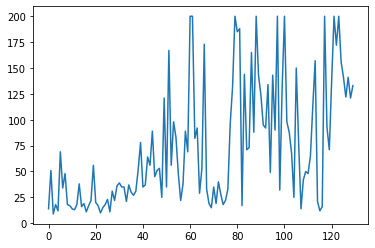

In [21]:
GAMMA = 0.99
ADVANTAGE = 5
MAX_ITER = 500
CLIP = 0.05
LR = 0.005

LR_STEP  = 100
LR_GAMMA = 0.9

AAA = Environment()
TTT = AAA.train()

X = range(len(TTT))
plt.plot(X, TTT)